## Bibliotecas a utilizar

In [1]:
%%capture
!pip install contractions

import re
import os
import nltk
import string
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions
import codecs


!wget -qO- -O stopwords_english.txt \
         https://raw.githubusercontent.com/pan-webis-de/authorid/master/data/stopwords_english.txt


# Creando una lista de stopwords
stopwords = []
for line in codecs.open('stopwords_english.txt', encoding = "utf-8"):
    # Remove black space if they exist
    stopwords.append(line.strip())
stopwords = dict.fromkeys(stopwords, True)


# Descargando el dataset
if not os.path.exists('train.json'):
  !wget https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/train.json
  !wget https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/dev.json

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# LegalEval: Understanding Legal Texts


## Analisis exploratorio

In [2]:
# Leyendo el conjunto de entrenamiento
f = open('train.json')
data = json.load(f)
f.close()

# Leyendo el conjunto de prueba
f = open('dev.json')
dev = json.load(f)
f.close()

Conociendo la estructura del dataset

In [3]:
for k,v  in data[0].items():
    print(f'{k} : {type(v)}')

id : <class 'int'>
annotations : <class 'list'>
data : <class 'dict'>
meta : <class 'dict'>


In [4]:
test_annotations = data[0]['annotations']
test_data = data[0]['data']
test_meta = data[0]['meta']

In [5]:
print(len(test_annotations[0]['result']))
print(type(test_annotations[0]['result']))
for x in test_annotations[0]['result']:
    print(x)
    break

91
<class 'list'>
{'id': 'd7a902fe9c23417499a7ef782f9fbdeb', 'type': 'labels', 'to_name': 'text', 'from_name': 'label', 'value': {'start': 0, 'end': 116, 'text': '      IN THE HIGH COURT OF KARNATAKA,\n          CIRCUIT BENCH AT GULBARGA\n\nDATED THIS THE 22ND DAY OF FEBRUARY, 2013', 'labels': ['PREAMBLE']}}


In [6]:
for k,v  in test_data.items():
    print(f'{k} : {type(v)} : {len(v)}')

text : <class 'str'> : 16540


In [7]:
for k,v  in test_meta.items():
    print(f'{k} : {type(v)} : {v}')

group : <class 'str'> : Criminal


In [8]:
for k,v  in dev[0].items():
    print(f'{k} : {type(v)}')

id : <class 'int'>
annotations : <class 'list'>
data : <class 'dict'>
meta : <class 'dict'>


In [9]:
for k,v  in data[0].items():
    print(f'{k} : {type(v)}')

id : <class 'int'>
annotations : <class 'list'>
data : <class 'dict'>
meta : <class 'dict'>


In [10]:
for x in test_annotations[0]['result']:
    print(type(x))
    print(x)
    break

<class 'dict'>
{'id': 'd7a902fe9c23417499a7ef782f9fbdeb', 'type': 'labels', 'to_name': 'text', 'from_name': 'label', 'value': {'start': 0, 'end': 116, 'text': '      IN THE HIGH COURT OF KARNATAKA,\n          CIRCUIT BENCH AT GULBARGA\n\nDATED THIS THE 22ND DAY OF FEBRUARY, 2013', 'labels': ['PREAMBLE']}}


In [11]:
def json_to_dataframe(data):
    id = []
    start = []
    end = []
    text = []
    label = []

    for d in data:
        id_text = d['id']
        for x in d['annotations']:
            info = x['result']
            for i in info:
                i_dict = i['value']
                id.append(id_text)
                start.append(i_dict['start'])
                end.append(i_dict['end'])
                text.append(i_dict['text'])
                label.append(i_dict['labels'][0])
            
    df_train = pd.DataFrame(list(zip(id,start,end,text,label)), columns=['id','start','end','text','label'])
    return(df_train)

In [12]:
df_train = json_to_dataframe(data)
df_train.drop_duplicates(inplace=True)
df_test = json_to_dataframe(dev)

In [13]:
print(df_train.shape)
df_train.head(5)

(28836, 5)


,id,start,end,text,label
0,1735,0,116,"IN THE HIGH COURT OF KARNATAKA,\n ...",PREAMBLE
1,1735,116,678,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,PREAMBLE
2,1735,678,964,This Criminal Appeal is filed under Section 37...,PREAMBLE
3,1735,964,1093,\n\n This appeal coming on for hearing t...,PREAMBLE
4,1735,1093,1180,\n Heard the learned Counsel for the app...,NONE


In [14]:
print(df_test.shape)
df_test.head(5)

(2890, 5)


,id,start,end,text,label
0,4180,0,95,PETITIONER:\nTHE COMMISSIONER OF INCOME-TAXNEW...,PREAMBLE
1,4180,95,143,\n\nDATE OF JUDGMENT:\n05/05/1961\n\nBENCH:\nD...,PREAMBLE
2,4180,143,581,"\nBENCH:\nDAS, S.K.\nHIDAYATULLAH, M.\nSHAH, J...",PREAMBLE
3,4180,582,774,It\nentered into transactions in the nature of...,PREAMBLE
4,4180,775,855,The assessee claimed deduction of these\nlosse...,PREAMBLE


In [15]:
df_train.label.unique()

array(['PREAMBLE', 'NONE', 'FAC', 'ARG_RESPONDENT', 'RLC',
       'ARG_PETITIONER', 'ANALYSIS', 'PRE_RELIED', 'RATIO', 'RPC',
       'ISSUE', 'STA', 'PRE_NOT_RELIED'], dtype=object)

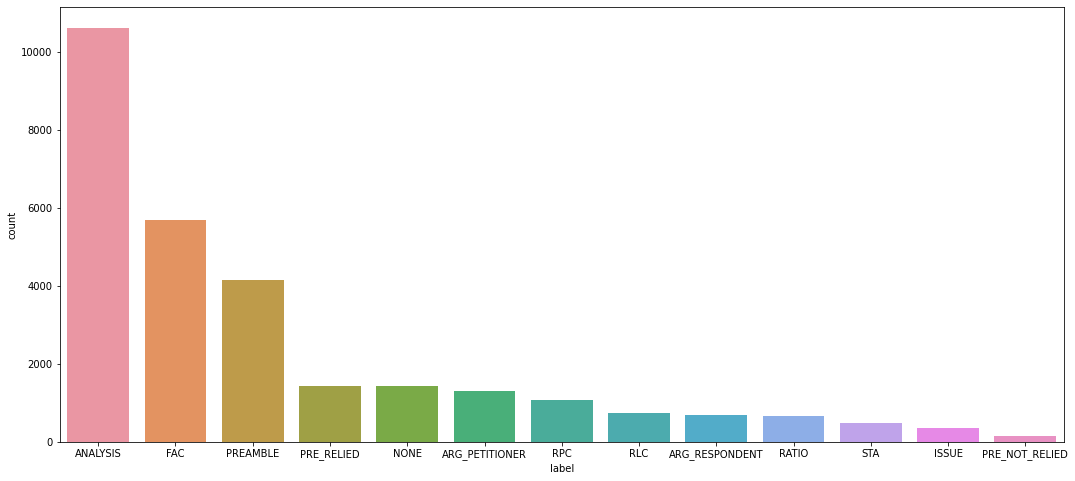

In [16]:
temp = df_train.groupby('label').agg(count=('label','count')).reset_index().sort_values('count', ascending=False)
plt.figure(figsize=(18,8))
sns.barplot(data=temp,
            x='label',
            y='count')
plt.show()

## Preprocesamiento

In [17]:
def sin_especiales(text):
  # Removemos signos de puntuación
  regex = '[' + string.punctuation + '\t\n¿,.–¡”“"]'  
  text = re.sub(regex, "", text)

  # Eliminamos espacio entre y afuera de las palabras
  text = re.sub(r'\s+', ' ', text).strip()

  # Transformamos minusculas
  text = text.lower()

  clean_text = text
  return clean_text

def sin_contracciones(text: str) -> str:  
  expanded_words = [contractions.fix(word) for word in text.split(" ")]
  return " ".join(expanded_words)  


def sin_stopwords(text: str) -> str:
  """Remove stop words"""
  tokens = nltk.word_tokenize(text)
  # Remove las stopwords
  without_stopwords = [word for word in tokens 
                       if not stopwords.get(word.lower().strip(), False)]
  return " ".join(without_stopwords)  

def clean_text(text):
  return sin_stopwords(sin_contracciones(sin_contracciones(sin_especiales(text))))

In [18]:
# Sin procesar
df_train['text']

0              IN THE HIGH COURT OF KARNATAKA,\n       ...
1        \n\n      BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...
2        This Criminal Appeal is filed under Section 37...
3        \n\n       This appeal coming on for hearing t...
4        \n       Heard the learned Counsel for the app...
                               ...                        
28981    \n So Section 132 of the Evidence Act sufficie...
28982    \n For the reasons aforesaid, the appeal is al...
28983    The judgment and order dated April 27, 1987 pa...
28984                                            \n R.S.S.
28985                                      Appeal allowed.
Name: text, Length: 28836, dtype: object

In [19]:
print(df_train['text'][3])



       This appeal coming on for hearing this day, the court
delivered the following :-

                              JUDGMENT


In [20]:
# Con procesar
df_train['sin_especiales'] = df_train['text'].apply(sin_especiales)
df_train['sin_contracciones'] = df_train['sin_especiales'].apply(sin_contracciones)
df_train['sin_stopwords'] = df_train['sin_contracciones'].apply(sin_stopwords)

df_train.head()

,id,start,end,text,label,sin_especiales,sin_contracciones,sin_stopwords
0,1735,0,116,"IN THE HIGH COURT OF KARNATAKA,\n ...",PREAMBLE,in the high court of karnataka circuit bench a...,in the high court of karnataka circuit bench a...,high court karnataka circuit bench gulbargadat...
1,1735,116,678,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,PREAMBLE,beforethe honble mrjustice anand byrareddy cri...,beforethe honble mrjustice anand byrareddy cri...,beforethe honble mrjustice anand byrareddy cri...
2,1735,678,964,This Criminal Appeal is filed under Section 37...,PREAMBLE,this criminal appeal is filed under section 37...,this criminal appeal is filed under section 37...,criminal appeal filed section 3742 thecode cri...
3,1735,964,1093,\n\n This appeal coming on for hearing t...,PREAMBLE,this appeal coming on for hearing this day the...,this appeal coming on for hearing this day the...,appeal coming hearing day courtdelivered judgment
4,1735,1093,1180,\n Heard the learned Counsel for the app...,NONE,heard the learned counsel for the appellant an...,heard the learned counsel for the appellant an...,heard learned counsel appellant learned govern...


In [21]:
df_train.to_csv('train.csv')

## LegalEval-Baseline




### Term Frequency–Inverse Document Frequency

In [22]:
# Ejemplo
corpus = [
    "The elephant sneezed at the sight of potatoes.",
    "Bats can see via echolocation. See the bat sight sneeze!",
    "Wondering, she opened the door to the studio.",
    ]

tfidf  = TfidfVectorizer()
corpus = tfidf.fit_transform(corpus)
corpus.todense()

matrix([[0.37867627, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.37867627, 0.37867627, 0.        , 0.37867627,
         0.        , 0.        , 0.28799306, 0.        , 0.37867627,
         0.        , 0.44730461, 0.        , 0.        , 0.        ],
        [0.        , 0.30251368, 0.30251368, 0.30251368, 0.        ,
         0.30251368, 0.        , 0.        , 0.        , 0.        ,
         0.60502736, 0.        , 0.23006945, 0.30251368, 0.        ,
         0.        , 0.17866945, 0.        , 0.30251368, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.36772387,
         0.        , 0.        , 0.        , 0.36772387, 0.        ,
         0.        , 0.36772387, 0.        , 0.        , 0.        ,
         0.36772387, 0.43436728, 0.36772387, 0.        , 0.36772387]])

### Datos originales

In [23]:
corpus = df_train['text'].apply(clean_text).tolist()
tfidf  = TfidfVectorizer()
corpus = tfidf.fit_transform(corpus)

corpus.shape

(28836, 30708)

In [24]:
df_train['label'].values.shape

(28836,)

## Modelo

Creando un conjunto de entrenamiento y validacion

In [26]:
from sklearn.model_selection import train_test_split

#X =  np.asarray(corpus.todense()) # Cast to matrix -> array
X = corpus
y = df_train[['label']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Probando con diferentes modelos

In [27]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=1.0e-10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                precision    recall  f1-score   support

      ANALYSIS       0.55      0.75      0.63      2127
ARG_PETITIONER       0.47      0.26      0.33       290
ARG_RESPONDENT       0.41      0.18      0.26       130
           FAC       0.55      0.51      0.53      1106
         ISSUE       0.62      0.20      0.30        76
          NONE       0.53      0.54      0.53       269
      PREAMBLE       0.74      0.56      0.64       843
PRE_NOT_RELIED       0.00      0.00      0.00        31
    PRE_RELIED       0.32      0.25      0.28       268
         RATIO       0.13      0.06      0.08       134
           RLC       0.32      0.19      0.24       147
           RPC       0.60      0.50      0.55       238
           STA       0.35      0.22      0.27       109

      accuracy                           0.55      5768
     macro avg       0.43      0.33      0.36      5768
  weighted avg       0.54      0.55      0.53      5768



In [28]:
model.score(X_train, y_train)

0.843809606381134